In [83]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [85]:
train_set = torchvision.datasets.MNIST('./data/', train=True, download=True)
valid_set = torchvision.datasets.MNIST('./data/', train=False, download=True)

In [86]:
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train

In [87]:
valid_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test

In [88]:
x_1, y_1 = train_set[1]

In [89]:
x_1

In [90]:
type(x_1)

PIL.Image.Image

In [91]:
y_1

0

In [92]:
type(y_1)

int

In [93]:
trans = transforms.Compose([transforms.ToTensor()])
x_1_tensor = trans(x_1)

In [94]:
x_1_tensor

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [95]:
type(x_1_tensor)

torch.Tensor

In [96]:
x_1_tensor.min()

tensor(0.)

In [97]:
x_1_tensor.max()

tensor(1.)

In [98]:
x_1_tensor.size()

torch.Size([1, 28, 28])

In [99]:
x_1_tensor.device

device(type='cpu')

In [100]:
x_1_gpu = x_1_tensor.cuda()
x_1_gpu.device

device(type='cuda', index=0)

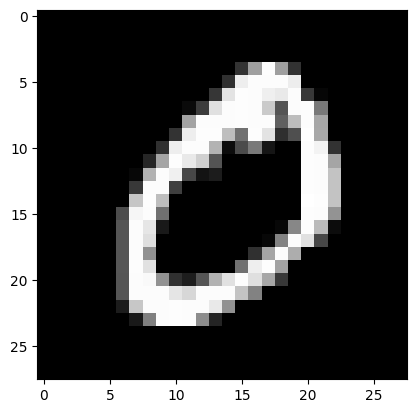

In [101]:
img = F.to_pil_image(x_1_tensor)
plt.imshow(img, cmap='gray')

In [102]:
train_set.transform = trans
valid_set.transform = trans

In [103]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [104]:
input_size = 1*28*28
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

In [105]:
model = nn.Sequential(*layers)


In [106]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [107]:
next(model.parameters()).device

device(type='cuda', index=0)

In [108]:
model = torch.compile(model, backend='eager')


In [109]:
optimizer = Adam(model.parameters())

In [110]:
loss_function = nn.CrossEntropyLoss()

In [111]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

In [112]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

In [113]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [114]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

In [115]:
epochs = 7
for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}/{epochs}')
    train()
    validate()


Epoch: 1/7
Train - Loss: 377.0512 Accuracy: 0.9383
Valid - Loss: 31.9292 Accuracy: 0.9684
Epoch: 2/7
Train - Loss: 157.1922 Accuracy: 0.9739
Valid - Loss: 28.3539 Accuracy: 0.9724
Epoch: 3/7
Train - Loss: 108.8130 Accuracy: 0.9819
Valid - Loss: 23.3186 Accuracy: 0.9796
Epoch: 4/7
Train - Loss: 82.3643 Accuracy: 0.9862
Valid - Loss: 23.4710 Accuracy: 0.9777
Epoch: 5/7
Train - Loss: 64.0459 Accuracy: 0.9888
Valid - Loss: 22.9682 Accuracy: 0.9783
Epoch: 6/7
Train - Loss: 58.6774 Accuracy: 0.9899
Valid - Loss: 25.9340 Accuracy: 0.9790
Epoch: 7/7
Train - Loss: 47.8152 Accuracy: 0.9918
Valid - Loss: 28.2946 Accuracy: 0.9802


In [116]:
predict = model(x_1_gpu)
predict

tensor([[ 20.2596, -18.8337,  -4.3844, -15.9517, -16.5656, -19.0461,  -4.6227,
         -14.5704, -14.6874, -12.2262]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [119]:
predict.argmax(dim=1, keepdim=True)

tensor([[0]], device='cuda:0')

In [120]:
y_1

0